# Utils 

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import tqdm as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import copy
import random
import time


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm.tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')


def recon_train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y, z,_) in tqdm.tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)
        z = z.to(device)
        optimizer.zero_grad()
        x_pred = model(z)
        loss = criterion(x_pred, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def recon_evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for (x, y, z,_) in tqdm.tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)
            x_pred = model(z)
            loss = criterion(x, x_pred)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


# Data preparation

In [1]:
import torchvision
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='.data',train=True,download=True)
testset = torchvision.datasets.CIFAR10(root='.data',train=False,download=True)


Files already downloaded and verified
Files already downloaded and verified


# Sampling 3D images

In [3]:
def sample2D(im,num_sampling):
    shape = im.shape
    im = im - im.min()
    im = im / im.sum()
    weights = torch.tensor(im.flatten(), dtype=torch.float) # create a tensor of weights
    samples = torch.multinomial(weights, num_sampling, replacement=True)
    samples_y, samples_x = np.unravel_index(samples, shape)
    X = np.array([samples_x,samples_y],np.float32)
    X = torch.tensor(X)
    X = X - X.mean()
    X = X / X.std()
    return X

def sample3D(im,num_sampling):
    im = torch.Tensor(im)
    X = [sample2D(im[:,:,C],num_sampling) for C in range(3)]
    X = torch.stack(X)
    X = X.reshape(3*2,-1)
    return X

def sample_images3D(imageset,num_sampling):
    samples = []
    for image, label in tqdm.tqdm(trainset):
        image = np.array(image)
        X = sample3D(image,num_sampling)
        samples.append((X,label,image))
    return samples

SAMPLING = 1024

train_sampled = sample_images3D(trainset,SAMPLING)
test_sampled = sample_images3D(testset,SAMPLING)

  0%|          | 0/50000 [00:00<?, ?it/s]<ipython-input-3-e70381905e3f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(im.flatten(), dtype=torch.float) # create a tensor of weights
100%|██████████| 50000/50000 [00:27<00:00, 1787.89it/s]


## Random Encoder

In [4]:

class MyMLP(nn.Module):
    def __init__(self, D, L, res):
        super().__init__()
        self.activ = F.relu
        self.fcs = [nn.Linear(D, D) for l in range(L)]
        for fc in self.fcs:
            # nn.init.xavier_normal_(w.weight,gain=1/np.sqrt(D))
            weights = torch.normal(0, 1.0/np.sqrt(D), size=fc.weight.shape)
            fc.weight.data = weights
        self.bns = [nn.BatchNorm1d(D) for l in range(L)]
        
        for li,(bn,fc) in enumerate(zip(self.bns,self.fcs)):
            self.add_module("fc_"+str(li), fc)
            self.add_module("bn_"+str(li), bn)
        self.L = L
        self.D = D
        self.res = res
        
    def layer_update(self, l,h):
        h2 = h
        h2 = self.activ(h2)
        h2 = self.fcs[l](h2)
        if l<len(self.fcs)-1:
            h2 = self.res * h + (1-self.res)*h2
        else:
            h2 = h
        h2 = my_layer_norm(h2)

        return h2


    def full_forward(self, h):
        shape = h.shape
        h = h.view(-1,h.shape[-1])
        h = my_layer_norm(h)
        H = [h.cpu().data.numpy()]
        for l in range(self.L):
            h = self.layer_update(l,h)
            H.append(h.view(shape).cpu().data.numpy())
        return H
    
    def forward(self, h):
        shape = h.shape
        h = h.view(-1,h.shape[-1])
        h = my_layer_norm(h)
        for l in range(self.L):
            h = self.layer_update(l,h)
        return h.view(shape)

    
def my_layer_norm(h):
    h = h - h.mean(1,True)
    h = h / h.std(1,keepdim=True)
    # h = h - h.mean()
    # h = h / h.std()
    return h


def show_layers(Hidden, Num=8,subplot=True,title=False,save_path=None):
    inds = np.linspace(1,len(Hidden)-1,num=Num,dtype=np.int32)
    Hidden = [Hidden[i] for i in inds]
    fig, axes = plt.subplots(1,Num,figsize=(2*Num,2))

    for Hi,(l,H) in enumerate(zip(inds,Hidden)):
        while H.shape[0]==1:
            H = H[0]
        H = H.reshape(3,2,-1)
        for C,col in zip(range(3),'rgb'):
            ax = axes[Hi]
            ax.scatter(H[C][0],-H[C][1],1,c=col,alpha=.1)
        if save_path:
            plt.savefig(f'{save_path}/{Hi}.png')


ENC_WIDTH = SAMPLING
ENC_LAYERS = 100
ENC_RES = .90

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

randNet = MyMLP(L=ENC_LAYERS,D=ENC_WIDTH,res=ENC_RES)
randNet = randNet.to(device)

r = np.random.randint(len(train_sampled))
X, y,im = train_sampled[r]
X = torch.unsqueeze(X,0).to(device)
Hidden = randNet.full_forward(X)
plt.imshow(im)
show_layers(Hidden)

In [5]:
def get_encodings(iterator, model):
    batches = []
    for (x, y, im) in tqdm.tqdm(iterator, leave=False):
            x = x.to(device)
            y = y.to(device)
            z = model(x)
            x,y,z = x.cpu(),y.cpu(),z.cpu()
            
            batches.append((x.data,y.data,z.data,im.data))
    encodings = [(x,y,z,im) for batch in batches for (x,y,z,im) in zip(*batch)]
    return encodings


ENC_BATCH_SIZE = 128

train_iterator = data.DataLoader(train_sampled,batch_size=ENC_BATCH_SIZE)
test_iterator = data.DataLoader(test_sampled,batch_size=ENC_BATCH_SIZE)
            
train_encodes = get_encodings(iterator=train_iterator,model=randNet)
test_encodes = get_encodings(iterator=test_iterator,model=randNet)

## Decoder Net

In [6]:
class MyMLP2(nn.Module):
    def __init__(self, input_dim, D, OUTPUT_DIM, L, res):
        super().__init__()
        self.activ = torch.nn.functional.relu
        self.fcs = [nn.Linear(D, D) for l in range(L)]
        self.fcs[0] = nn.Linear(input_dim,D)
        self.fcs[-1] = nn.Linear(D,OUTPUT_DIM)
        for w in self.fcs:
            weights = torch.normal(0, 1.0/np.sqrt(D), size=w.weight.shape)
            w.weight.data = weights
        
        for li,layer in enumerate(self.fcs):
            self.add_module("hidden_layer_"+str(li), layer)
        self.L = L
        self.D = D
        self.res = res
        
    def layer_update(self, l,h):
        h2 = h
        h2 = self.activ(h2)
        h2 = self.fcs[l](h2)
        if l<len(self.fcs)-1:
            h2 = self.res * h + (1-self.res)*h2
        else:
            h2 = h
        h2 = my_layer_norm(h2)
        return h2


    def forward(self, h):
        shape = h.shape
        h = h.view(-1,h.shape[-1])

        for l in range(self.L):
            h = self.layer_update(l,h)
        return h.view(shape)
    

    def full_forward(self, h):
        shape = h.shape
        h = h.view(-1,h.shape[-1])
        h = my_layer_norm(h)
        H = [h.cpu().data.numpy()]
        for l in range(self.L):
            h = self.layer_update(l,h)
            H.append(h.view(shape).cpu().data.numpy())
        return H

LAYERS = 100
RES = .90 # 1 - 1.0/LAYERS

INPUT_DIM = SAMPLING 
WIDTH = SAMPLING
OUTPUT_DIM = INPUT_DIM


model = MyMLP2(INPUT_DIM, WIDTH,OUTPUT_DIM, LAYERS,RES).to(device)

Epoch: 0	Train Loss: 1.80761	 Val. Loss: 0.85682


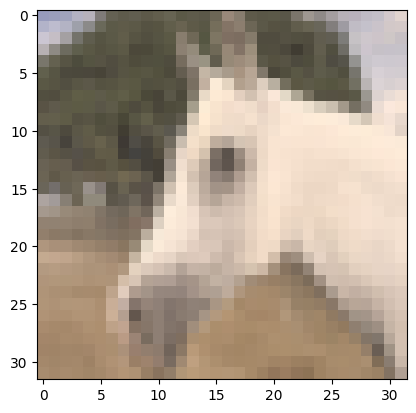

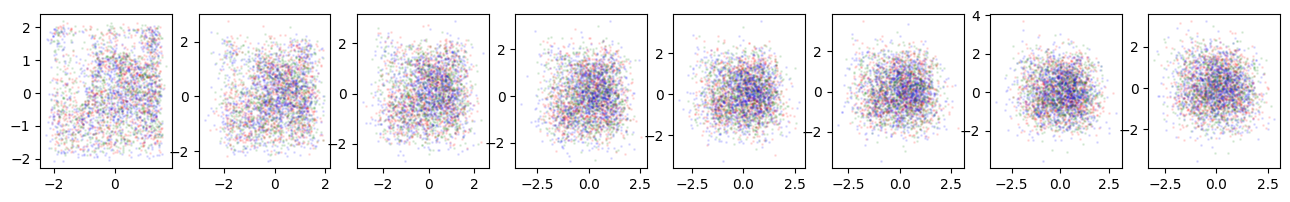

Epoch: 1	Train Loss: 0.38443	 Val. Loss: 0.25048


Epoch: 2	Train Loss: 0.22856	 Val. Loss: 0.21776


Epoch: 3	Train Loss: 0.19734	 Val. Loss: 0.17745


Epoch: 4	Train Loss: 0.16320	 Val. Loss: 0.14665


Epoch: 5	Train Loss: 0.14183	 Val. Loss: 0.13274


Epoch: 6	Train Loss: 0.13146	 Val. Loss: 0.12640


Epoch: 7	Train Loss: 0.12787	 Val. Loss: 0.13191


Epoch: 8	Train Loss: 0.12700	 Val. Loss: 0.12838


Epoch: 9	Train Loss: 0.12638	 Val. Loss: 0.12784


Epoch: 10	Train Loss: 0.12584	 Val. Loss: 0.13324


Epoch: 11	Train Loss: 0.12492	 Val. Loss: 0.12338


Epoch: 12	Train Loss: 0.12114	 Val. Loss: 0.12225


Epoch: 13	Train Loss: 0.11901	 Val. Loss: 0.11935


Epoch: 14	Train Loss: 0.11715	 Val. Loss: 0.11313


Epoch: 15	Train Loss: 0.11506	 Val. Loss: 0.11390


Epoch: 16	Train Loss: 0.11316	 Val. Loss: 0.10978


Epoch: 17	Train Loss: 0.11299	 Val. Loss: 0.10772


Epoch: 22	Train Loss: 0.10626	 Val. Loss: 0.10774


Epoch: 23	Train Loss: 0.10376	 Val. Loss: 0.10726


Epoch: 24	Train Loss: 0.10474	 Val. Loss: 0.10729


Epoch: 25	Train Loss: 0.10287	 Val. Loss: 0.10432


Epoch: 26	Train Loss: 0.10336	 Val. Loss: 0.10688


Epoch: 27	Train Loss: 0.10269	 Val. Loss: 0.10679


Epoch: 28	Train Loss: 0.10138	 Val. Loss: 0.10415


Epoch: 29	Train Loss: 0.10022	 Val. Loss: 0.10395


Epoch: 30	Train Loss: 0.09970	 Val. Loss: 0.10188


Epoch: 31	Train Loss: 0.09774	 Val. Loss: 0.09568


Epoch: 32	Train Loss: 0.09825	 Val. Loss: 0.09533


Epoch: 33	Train Loss: 0.09673	 Val. Loss: 0.09815


Epoch: 34	Train Loss: 0.09716	 Val. Loss: 0.09692


Epoch: 35	Train Loss: 0.09603	 Val. Loss: 0.09902


Epoch: 36	Train Loss: 0.09587	 Val. Loss: 0.09896


Epoch: 37	Train Loss: 0.09690	 Val. Loss: 0.09504


Epoch: 38	Train Loss: 0.09706	 Val. Loss: 0.09960


Epoch: 39	Train Loss: 0.09547	 Val. Loss: 0.09292


Epoch: 40	Train Loss: 0.09345	 Val. Loss: 0.09148


Epoch: 41	Train Loss: 0.09333	 Val. Loss: 0.09506


Epoch: 42	Train Loss: 0.09381	 Val. Loss: 0.09516


Epoch: 43	Train Loss: 0.09534	 Val. Loss: 0.09368


Epoch: 44	Train Loss: 0.09368	 Val. Loss: 0.09448


KeyboardInterrupt: 

In [7]:
        
def sample_plot(Repeat=5, W=2, KDE=False):
    for param in model.parameters():
        param.requires_grad = False
    fig, axes = plt.subplots(3, Repeat,figsize=(Repeat*W,3*W))
    for ai in range(Repeat):
        X,y,Z,im = test_encodes[np.random.randint(len(test_encodes))]
        Z = Z.view(2,-1)
        X_pred = model(torch.unsqueeze(Z,0).to(device))
        X_pred = X_pred.view(2,-1).cpu().data
        X = X.cpu().data.numpy()
        for aj,A in enumerate([X,Z,X_pred]):
            ax = axes[aj][ai]
            if KDE:
                sns.kdeplot(ax=ax,x=A[0],y=-A[1],fill=True,bw_adjust=.5)
            else:
                ax.scatter(A[0],-A[1],1)
            ax.set_xlim(-4,4)
            ax.set_ylim(-3,3)
            ax.set_xticks([])
            ax.set_yticks([])

    for param in model.parameters():
        param.requires_grad = True
    fig.show()
    plt.savefig(f'fig{int(KDE)}.png')
    
BATCH_SIZE = 512
EPOCHS = 1000
criterion = nn.MSELoss().to(device)


train_iterator = data.DataLoader(train_encodes, shuffle=True, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_encodes, batch_size=BATCH_SIZE)

best_valid_loss = float('inf')
optimizer = optim.Adam(model.parameters())
for epoch in range(EPOCHS):
    train_loss = recon_train(model, train_iterator, optimizer, criterion, device)
    valid_loss = recon_evaluate(model, test_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'Epoch: {epoch}\tTrain Loss: {train_loss:.5f}\t Val. Loss: {valid_loss:.5f}')
    # sample_plot(10,2)
    plt.show()

In [8]:
X,y,Z,im = test_encodes[np.random.randint(len(test_encodes))]

Hidden = randNet.full_forward(torch.unsqueeze(X,0).to(device))
Z = torch.tensor(Hidden[-1])
Hidden2 = model.full_forward(torch.unsqueeze(Z,0).to(device))
plt.figure(figsize=(5,5))
plt.imshow(im[:,:,])
plt.figure()
show_layers(Hidden, Num=8)
show_layers(Hidden2, Num=8)



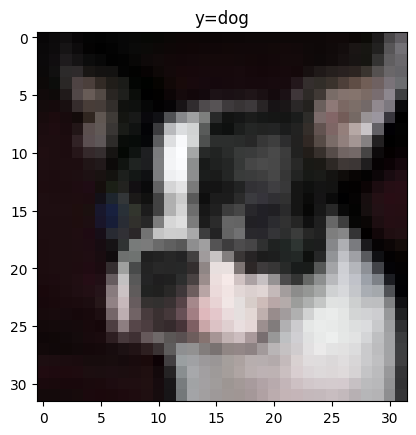

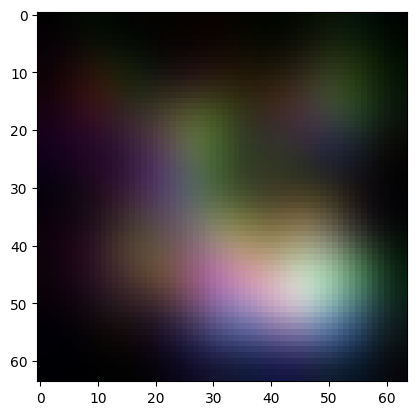

In [55]:
import scipy.ndimage as ndimage

cats = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


X,y,Z,im = test_encodes[np.random.randint(len(test_encodes))]

Hidden = randNet.full_forward(torch.unsqueeze(X,0).to(device))
Z = torch.tensor(Hidden[-1])
Hidden2 = model.full_forward(torch.unsqueeze(Z,0).to(device))

H = Hidden2[-1]
H = H.reshape(3,2,-1)
D = 64
h = np.zeros((D,D,3))
for C in range(3):
    hC,_,_ = np.histogram2d(H[C,0],H[C,1],[D,D])
    hC = hC / hC.max() * im[:,:,C].max().data.numpy()
    hC = hC / hC.mean() * (im[:,:,C].data.numpy()).mean()
    hC = ndimage.gaussian_filter(hC.astype(int), sigma=(4, 4), order=0)
    h[:,:,C] = hC * .7
h = h.swapaxes(0,1)
h = h.astype(int)

plt.figure()
plt.imshow(im)
plt.title(f'y={cats[y]}')
plt.figure()
plt.imshow(h)
plt.show()

# Differential updates: is $\|H_{\ell+1}-H_\ell\|$ informative?

In [20]:
colors = 'rgbcmykw'
Vals = [[] for _ in range(10)]

for rep in tqdm.trange(10000):
    X,y,Z,im = test_encodes[np.random.randint(len(test_encodes))]

    Hidden2 = model.full_forward(torch.unsqueeze(Z,0).to(device))
    H = [Hidden2[0]]
    H = H + [h[0] for h in Hidden2[1:]]
    H = np.array(H)
    H = H.reshape(H.shape[0],-1)
    Hd = np.diff(H,axis=0)
    Hd = np.sum(Hd**2,1)
    Vals[y].append(Hd)
Vals = [np.array(Hd) for Hd in Vals]

100%|██████████| 10000/10000 [03:04<00:00, 54.16it/s]


In [21]:
from scipy.stats import rankdata
M = [Vals[y][:,:-1] for y in range(10)]
M = np.concatenate(M,axis=0)
ys = [y for y in range(10) for j in range(Vals[y].shape[0])]
for c in range(M.shape[1]):
    M[:,c] = (rankdata(M[:,c])-1)/M.shape[0]
    
rands = np.random.randint(10000,size=500)
cats = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
colors = 'rgbcmykw'
fig,axes = plt.subplots(10,1,figsize=(15,40))
c2c = {i:0 for i in range(10)}
for i,r in enumerate(rands):
    y = ys[r]
    ax = axes[y]
    c2c[y] += 1
    if c2c[y]>=20:
        continue
    if c2c[y]==1:
        ax.set_title(f'{cats[y]}')
    ax.set_xticks([])
    mu = M[r,:]#/np.median(M[r,:])
    # mu = mu/np.std(mu)
    ax.plot(mu+c2c[y]*.3,alpha=1)
# plt.legend([cats[ys[i]] for i in rands])

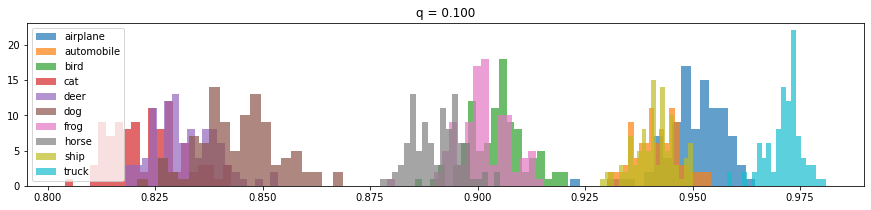

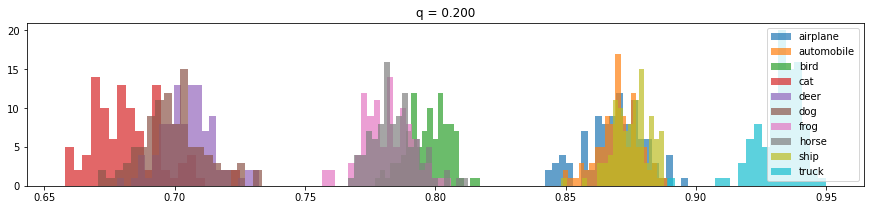

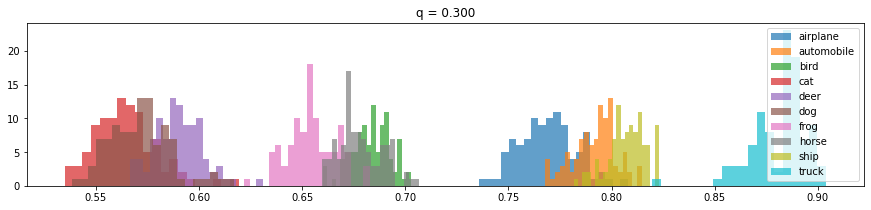

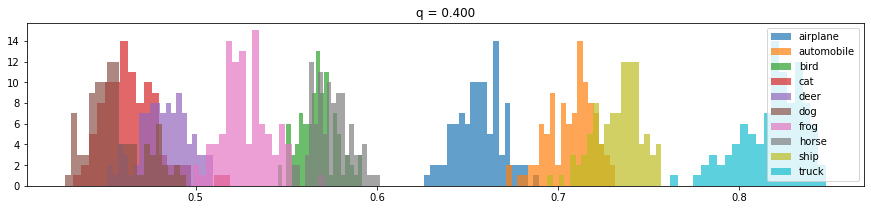

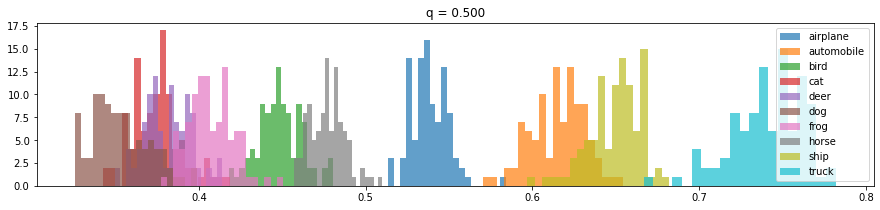

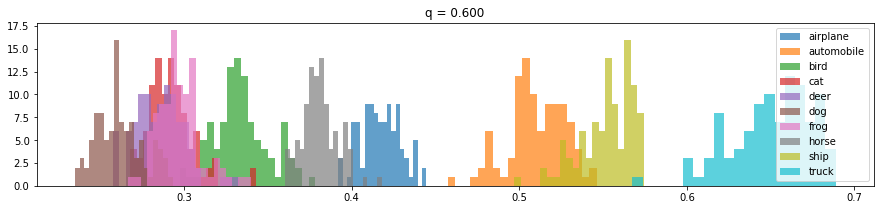

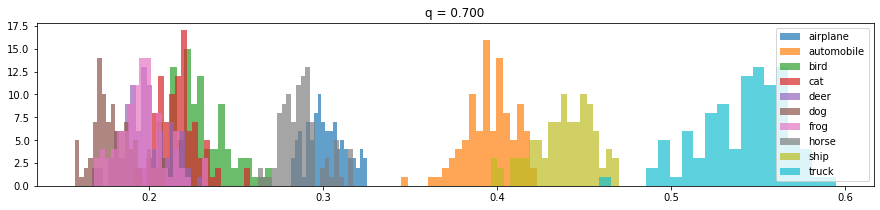

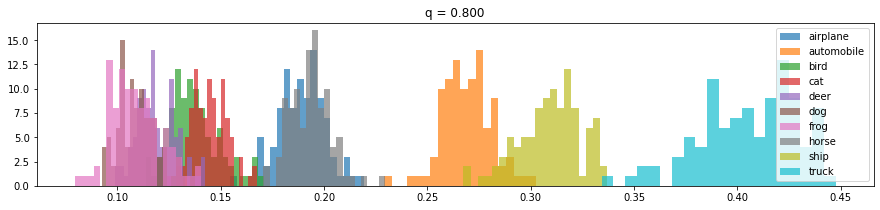

In [285]:


for q in np.arange(0.1,.9,.1):
    Q = np.quantile(M,axis=0,q=q)
    plt.figure(figsize=(15,3))
    ys = range(10)
    for y in ys:
        M2 = np.mean(Vals[y][:,:-1]>Q[np.newaxis:,],0)
        M2 = Vals[y][:,:-1]>Q[np.newaxis:,]
        M2 = np.mean(M2,0)
        plt.hist(M2,20,alpha=.7)
    plt.legend(cats)
    plt.title(f'q = {q:.3f}')

truck
ship
automobile
airplane
horse
bird
frog
deer
cat
dog
